# ADVANCED DATA SCIENCE WITH IBM 
## COVID 19 - Predict
The development of this document is to approve the Final report on **Advanced Data Science Capstone**, it explain all about the topic and the development on it.
Currently COVID 19 (June 2020) is the biggest problem in the world, not only because of the impact but also the deaths, this project takes the data set offered by: [Dataset](https://www.kaggle.com/lalish99/covid19-mx/data?select=covid-19_general_MX.csv)

Design a supervised machine learning that can predict whether or not a patient has COVID-19, with their age and previous illnesses, and the implementation of different algorithms to solve the problem.

This problem was designed in local jupyter notebook with Python 3.6.\
Autor: Kevin Joven

In [1]:
#Import all the libreries that we need.
from pyspark import SparkContext, SparkConf
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession \
    .builder \
    .appName("COVID-19 Predict") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
#Download the dataset and place it in the folder on your laptop (DatosCVD.csv).
df = spark.read.format("csv").option("header", "true").load("DatosCVD.csv")

## 1. Principal Features 
NUM (Number): Pacient number.\
SEXO (Sex) : 1- Women 2- Men - 98 -Others\
EDAD (Age) : Person age.\
Previus Issues: NEUMONIA - DIABETES - EPOC - ASMA - HIPERTENSION - CARDIOVASCULAR - OBESIDAD - TABAQUISMO - 1 - Si - 2 - No - Does Apply - 98 is ignored - 99 Not specified.\
RESULTADO (Result) : Has or not COVID - 1- Yes 2- No 3- Pendient

In [2]:
Datos = df.select(df._c0.alias('NUM'),df.SEXO,df.EDAD,df.NEUMONIA,df.DIABETES,df.EPOC,df.ASMA,df.HIPERTENSION
          ,df.CARDIOVASCULAR,df.OBESIDAD,df.TABAQUISMO,df.RENAL_CRONICA.alias('RENAL'),df.RESULTADO)
Datos.show(10)

+---+----+----+--------+--------+----+----+------------+--------------+--------+----------+-----+---------+
|NUM|SEXO|EDAD|NEUMONIA|DIABETES|EPOC|ASMA|HIPERTENSION|CARDIOVASCULAR|OBESIDAD|TABAQUISMO|RENAL|RESULTADO|
+---+----+----+--------+--------+----+----+------------+--------------+--------+----------+-----+---------+
|  0|   2|  27|       2|       2|   2|   2|           2|             2|       2|         2|    2|        1|
|  1|   1|  52|       2|       1|   2|   2|           1|             1|       2|         2|    2|        1|
|  2|   1|  55|       2|       1|   2|   2|           1|             2|       1|         2|    2|        1|
|  3|   1|  38|       2|       2|   2|   2|           2|             2|       2|         2|    2|        1|
|  4|   2|  59|       2|       2|   2|   2|           2|             2|       2|         2|    2|        1|
|  5|   1|  67|       2|       1|   2|   1|           2|             2|       2|         2|    2|        1|
|  6|   2|  36|       2|    

## 2. Feature Enginering
Here we convert the original dataset to a dataset that does not contain extreme values or unspecified values, (previous illnesses), we remove that data from the original dataset, along with adjusting the values from 0 to 1, and modifying the age within an equivalent range ( for our case less than 80 years), however there are other techniques such as IQR.
The ages corresponding to 0 correspond to a newborn.

In [3]:
Datos.select('EDAD').summary().show()

+-------+------------------+
|summary|              EDAD|
+-------+------------------+
|  count|            401755|
|   mean| 42.57662505755996|
| stddev|16.695685188876595|
|    min|                 0|
|    25%|              31.0|
|    50%|              41.0|
|    75%|              53.0|
|    max|                99|
+-------+------------------+



In [4]:
Datos.createOrReplaceTempView('Datos')
Datossql = spark.sql("""

SELECT CAST(NUM AS INT),
CAST(EDAD AS INT),
CAST(REPLACE(REPLACE(SEXO,1,0),2,1) AS INT) AS SEXO,
CAST(REPLACE(REPLACE(ASMA,2,0),1,1) AS INT) AS ASMA,
CAST(REPLACE(REPLACE(NEUMONIA,2,0),1,1) AS INT) AS NEUMONIA,
CAST(REPLACE(REPLACE(DIABETES,2,0),1,1) AS INT) AS DIABETES,
CAST(REPLACE(REPLACE(EPOC,2,0),1,1) AS INT) AS EPOC,
CAST(REPLACE(REPLACE(HIPERTENSION,2,0),1,1) AS INT) AS HIPERTENSION,
CAST(REPLACE(REPLACE(CARDIOVASCULAR,2,0),1,1) AS INT) AS CARDIOVASCULAR,
CAST(REPLACE(REPLACE(OBESIDAD,2,0),1,1) AS INT) AS OBESIDAD,
CAST(REPLACE(REPLACE(TABAQUISMO,2,0),1,1) AS INT) AS TABAQUISMO,
CAST(REPLACE(REPLACE(RENAL,2,0),1,1) AS INT) AS RENAL,
CAST(REPLACE(REPLACE(RESULTADO,2,0),1,1) AS INT) AS RESULTADO


from Datos

WHERE ASMA != 97 AND ASMA != 98 AND ASMA != 99 AND
TABAQUISMO != 97 AND TABAQUISMO != 98 AND TABAQUISMO != 99 AND
RESULTADO != 3 AND
EDAD < 80 AND
NEUMONIA != 97 AND NEUMONIA != 98 AND NEUMONIA != 99 AND
DIABETES != 97 AND DIABETES != 98 AND DIABETES != 99 AND
EPOC != 97 AND EPOC != 98 AND EPOC != 99 AND
HIPERTENSION != 97 AND HIPERTENSION != 98 AND HIPERTENSION != 99 AND
CARDIOVASCULAR != 97 AND CARDIOVASCULAR != 98 AND CARDIOVASCULAR != 99 AND
RENAL != 97 AND RENAL != 98 AND RENAL != 99 AND
OBESIDAD != 97 AND OBESIDAD != 98 AND OBESIDAD != 99

""")
Datossql.show(5)
Datossql.count()

+---+----+----+----+--------+--------+----+------------+--------------+--------+----------+-----+---------+
|NUM|EDAD|SEXO|ASMA|NEUMONIA|DIABETES|EPOC|HIPERTENSION|CARDIOVASCULAR|OBESIDAD|TABAQUISMO|RENAL|RESULTADO|
+---+----+----+----+--------+--------+----+------------+--------------+--------+----------+-----+---------+
|  0|  27|   1|   0|       0|       0|   0|           0|             0|       0|         0|    0|        1|
|  1|  52|   0|   0|       0|       1|   0|           1|             1|       0|         0|    0|        1|
|  2|  55|   0|   0|       0|       1|   0|           1|             0|       1|         0|    0|        1|
|  3|  38|   0|   0|       0|       0|   0|           0|             0|       0|         0|    0|        1|
|  4|  59|   1|   0|       0|       0|   0|           0|             0|       0|         0|    0|        1|
+---+----+----+----+--------+--------+----+------------+--------------+--------+----------+-----+---------+
only showing top 5 rows



334943

### Some Statistics
We calculated the histogram of people with COVID and without COVID, their boxplot and the correlation between each of the previous diseases depending on the age of the patients.

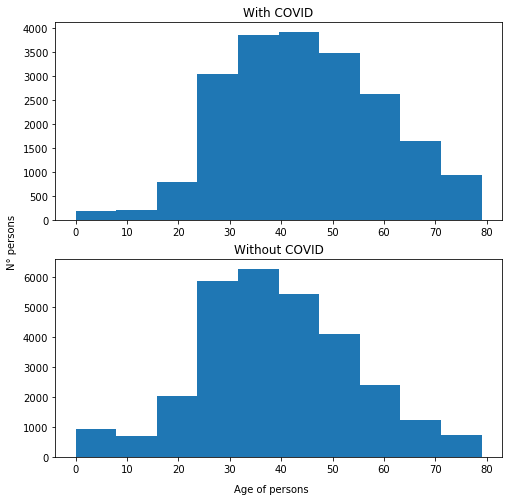

In [5]:
plt.rcParams["figure.figsize"] = (8,8) #Modify the figure size.
X = Datossql.filter('RESULTADO=1').select('EDAD').sample(False,0.15).rdd.map(lambda x: x.EDAD).sortBy(lambda x:x).collect()
Y = Datossql.filter('RESULTADO=0').select('EDAD').sample(False,0.15).rdd.map(lambda x: x.EDAD).sortBy(lambda x:x).collect()
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.hist(X)
ax2.hist(Y)
fig.text(0.5, 0.07, 'Age of persons', ha='center', va='center')
fig.text(0.05, 0.5, 'N° persons', ha='center', va='center', rotation='vertical')
ax1.set_title('With COVID')
ax2.set_title('Without COVID')
plt.show()

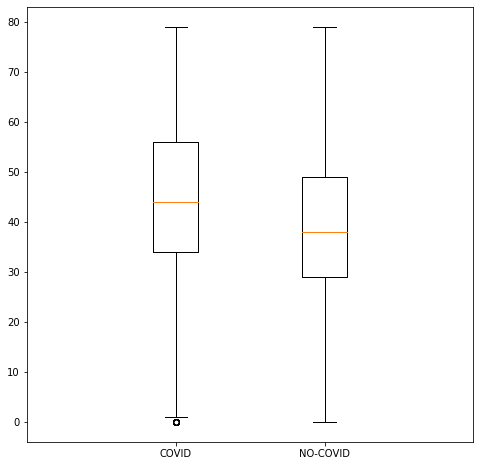

In [6]:
plt.boxplot(X, positions = [0.5])
plt.boxplot(Y, positions = [1])
ticks=[0.5,1]
labels=['COVID', 'NO-COVID']
plt.xticks(ticks, labels)
plt.show()

### Correlations

In [7]:
#Now we calculated the correlation between the RESULTADO and the others features.
R1 = Datossql.corr('EDAD','RESULTADO')
R2 = Datossql.corr('SEXO','RESULTADO')
R3 = Datossql.corr('ASMA','RESULTADO')
R4 = Datossql.corr('TABAQUISMO','RESULTADO')
R5 = Datossql.corr('EPOC','RESULTADO')
R6 = Datossql.corr('HIPERTENSION','RESULTADO')
R7 = Datossql.corr('CARDIOVASCULAR','RESULTADO')
R8 = Datossql.corr('OBESIDAD','RESULTADO')
R9 = Datossql.corr('RENAL','RESULTADO')
COR = [R1,R2,R3,R4,R5,R6,R7,R8,R9]
print(COR)

[0.17960791369644316, 0.07914576754244484, -0.02835243446442051, -0.021751394515616956, 0.00932128618786566, 0.08771693933290145, 0.002750673802632613, 0.07865455095253637, 0.011100631711930122]


## 3. SYSTEM MODELING
Now we choose a classifier to accurately predict the type of patients that arrive, we will use various classification systems, in this case binary since it will only be predicting whether or not you have COVID.

In [8]:
from pyspark.ml.feature import VectorAssembler,SQLTransformer
from pyspark.ml.classification import LinearSVC, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes, MultilayerPerceptronClassifier, OneVsRest, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [9]:
D = Datossql.sample(False,0.001) #We can use a bigger or smaller cuantity - 0.001
D = D.select(D.RESULTADO.alias("label"),D.EDAD,D.SEXO,D.ASMA,D.TABAQUISMO,D.EPOC,D.HIPERTENSION,
             D.CARDIOVASCULAR,D.OBESIDAD,D.RENAL)
vectorAssembler = VectorAssembler(inputCols=['EDAD','SEXO','ASMA','TABAQUISMO','EPOC','HIPERTENSION',
                                             'CARDIOVASCULAR','OBESIDAD','RENAL'],outputCol = 'features')

### LinearSVC Classifier

In [11]:
classifier = LinearSVC(maxIter=5,regParam=0.01)
pipeline = Pipeline(stages=[vectorAssembler, classifier])
model = pipeline.fit(D)
prediction = model.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction)

0.5055485242577604

### GBT Classifier

In [10]:
classifier2 = GBTClassifier(maxDepth=30,maxIter=20)
pipeline2 = Pipeline(stages=[vectorAssembler, classifier2])
model2 = pipeline2.fit(D)
prediction2 = model2.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction2)

0.9034771939102528

### Logistic Rregresion

In [260]:
classifier3 = LogisticRegression()
pipeline3 = Pipeline(stages=[vectorAssembler, classifier3])
model3 = pipeline3.fit(D)
prediction3 = model3.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction3)

0.441315056133217

### Decision Tree Classifier

In [261]:
classifier4 = DecisionTreeClassifier(maxDepth=25)
pipeline4 = Pipeline(stages=[vectorAssembler, classifier4])
model4 = pipeline4.fit(D)
prediction4 = model4.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction4)

0.435318397554313

### Random Forest Classifier

In [12]:
classifier5 = RandomForestClassifier(numTrees=30)
pipeline5 = Pipeline(stages=[vectorAssembler, classifier5])
model5 = pipeline5.fit(D)
prediction5 = model5.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction5)

0.7284285642925457

### Naive Bayes

In [263]:
classifier6 = NaiveBayes()
pipeline6 = Pipeline(stages=[vectorAssembler, classifier6])
model6 = pipeline6.fit(D)
prediction6 = model6.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction6)

0.3445630481871859

### Multilayer Perceptron Classifier

In [270]:
classifier7 = MultilayerPerceptronClassifier(maxIter=100, layers=[9,200,200, 2], blockSize=1000, seed=None)
pipeline7 = Pipeline(stages=[vectorAssembler, classifier7])
model7 = pipeline7.fit(D)
prediction7 = model7.transform(D)
binEval = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
binEval.evaluate(prediction7)

0.452591135160586

**As a summary GBTClassifier has a much higher precision compared to other classifiers, so it will be the model that we will use for the execution of the project.**